<a href="https://colab.research.google.com/github/vvjft/DL_BIQA/blob/main/CNN%2B%2BIQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import scipy
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
!wget https://www.ponomarenko.info/tid2013/tid2013.rar # tid2013

from google.colab import drive
drive.mount('/content/drive') # LIVE

--2024-06-13 02:41:31--  https://www.ponomarenko.info/tid2013/tid2013.rar
Resolving www.ponomarenko.info (www.ponomarenko.info)... 77.37.42.155, 2a02:4780:21:8ac:c985:e184:9822:365f
Connecting to www.ponomarenko.info (www.ponomarenko.info)|77.37.42.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 957680241 (913M) [application/x-rar-compressed]
Saving to: ‘tid2013.rar’

tid2013.rar         100%[===================>] 913.31M  22.4MB/s    in 1m 57s  

2024-06-13 02:43:30 (7.80 MB/s) - ‘tid2013.rar’ saved [957680241/957680241]

Mounted at /content/drive


In [3]:
!mkdir -p '/content/tid2013'
!unrar x -inul '/content/tid2013.rar' '/content/tid2013'
!rm '/content/tid2013.rar'
!rm -r '/content/tid2013/metrics_values'
!rm -r '/content/tid2013/papers'
!rm '/content/tid2013/readme'
!rm -r '/content/sample_data'

!cp -r /content/drive/MyDrive/magisterka/LIVEIQA_release2 /content
os.rename('/content/LIVEIQA_release2', '/content/LIVE')
drive.flush_and_unmount()

In [4]:
from scipy.optimize import curve_fit

def logistic_function(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x - d))) + b

def get_logistic_fun(data_tid, data_live):
  def convert_mos_to_dmos(mos, dmos):
      initial_params = [0, 0, 0, np.median(mos)]  # initial guess for parameters
      popt, _ = curve_fit(logistic_function, mos, dmos, p0=initial_params, maxfev=10000)
      return popt

  train_data_tid, val_data_tid, test_data_tid = split_data(data_tid)
  train_data_live, val_data_live, test_data_live = split_data(data_live)
  # Align MOS and DMOS for fitting
  mos_train = np.sort(train_data_tid['MOS'].values)
  dmos_train = np.sort(train_data_live['DMOS'].values[:len(mos_train)])[::-1]  # ensure lengths match for curve fitting

  params = convert_mos_to_dmos(mos_train, dmos_train)
  #print("Estimated parameters:", params)
  data_tid['DMOS_pred'] = logistic_function(data_tid['MOS'].values, *params)

  plt.scatter(data_tid['MOS'], data_tid['DMOS_pred'], label='Predicted DMOS', alpha=0.5)
  plt.scatter(mos_train, dmos_train, label='Actual DMOS (Training Data)', alpha=0.5)
  plt.title('Logistic mapping (MOS to DMOS)')
  plt.xlabel('MOS')
  plt.ylabel('DMOS')
  plt.legend()
  plt.grid(True)
  plt.show()

  return params

In [5]:
from scipy.signal import convolve2d
def normalize_and_slice(db_dir, train_data, val_data, test_data, patch_size=32, cross=False):

  def local_normalize(patch, P=3, Q=3, C=1):
      kernel = np.ones((P, Q)) / (P * Q)
      patch_mean = convolve2d(patch, kernel, boundary='symm', mode='same')
      patch_sm = convolve2d(np.square(patch), kernel, boundary='symm', mode='same')
      patch_std = np.sqrt(np.maximum(patch_sm - np.square(patch_mean), 0)) + C
      patch_ln = (patch - patch_mean) / patch_std
      return patch_ln.astype('float32')

  sets = {'train': [train_data, 'training'], 'val':[val_data, 'validation'], 'test':[test_data, 'test']}

  for key, (data, name) in sets.items():
    if cross==True and name=='test':
      db_dir = 'tid2013'

    output_dir_full = f'{db_dir}/normalized_distorted_images/{name}/full/' # where to store normalized distorted images
    output_dir_patches = f'{db_dir}/normalized_distorted_images/{name}/patches/' # where to store patches
    norm_file_info_path = f'{db_dir}/normalized_distorted_images/{name}/norm_{name}.csv'
    patch_file_info_path = f'{db_dir}/normalized_distorted_images/{name}/patch_{name}.csv'
    os.makedirs(output_dir_full, exist_ok=True)
    os.makedirs(output_dir_patches, exist_ok=True)

    norm_info_list = []
    patch_info_list = []

    for index, row in data.iterrows():
        image_filename = row[0]
        mos_value = row[1]
        distortion = row[2]
        image_path = f'{db_dir}/distorted_images/{image_filename}'
        image = cv2.imread(image_path)

        if image is None:
            print(f"Failed to load image: {image_filename}")
            continue

        # Normalize the image
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_normalized = local_normalize(image_gray)
        # Save
        image_filename = f'NORM_{image_filename}'
        norm_info_list.append([image_filename, mos_value, distortion])
        cv2.imwrite(output_dir_full+image_filename, image_normalized)
        # Slice to patches
        height, width = image_normalized.shape[:2]
        num_patches_y = height // patch_size
        num_patches_x = width // patch_size
        patch_count = 0
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                patch = image_normalized[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
                patch_path = os.path.join(output_dir_patches, f"{os.path.splitext(image_filename)[0]}_patch_{patch_count}.bmp")
                patch_filename = f"{os.path.splitext(image_filename)[0]}_patch_{patch_count}.bmp"
                cv2.imwrite(patch_path, patch)
                # Add patch info to the list
                patch_info_list.append([patch_filename, mos_value, distortion])
                patch_count += 1

    norm_info_df = pd.DataFrame(norm_info_list, columns=['image_filename', score_measure, 'Distortion'])
    norm_info_df.to_csv(norm_file_info_path, index=False)
    print(f"[{name}]: Saved full normalized distorted image info to:\n{patch_file_info_path}.")
    patch_info_df = pd.DataFrame(patch_info_list, columns=['image_filename', score_measure, 'Distortion'])
    patch_info_df.to_csv(patch_file_info_path, index=False)
    print(f"[{name}]: Saved patch info to {patch_file_info_path}.")

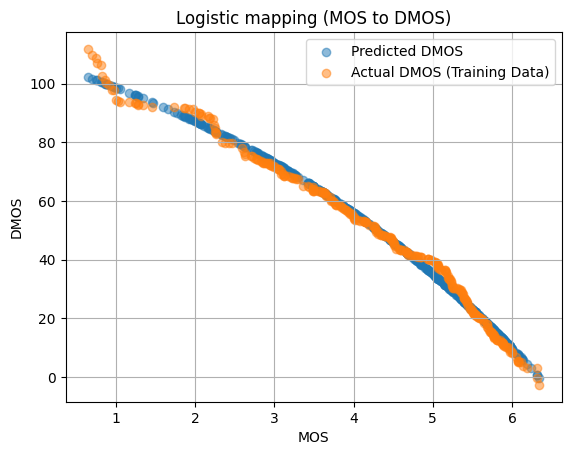

[training]: Saved full normalized distorted image info to:
LIVE/normalized_distorted_images/training/patch_training.csv.
[training]: Saved patch info to LIVE/normalized_distorted_images/training/patch_training.csv.
[validation]: Saved full normalized distorted image info to:
LIVE/normalized_distorted_images/validation/patch_validation.csv.
[validation]: Saved patch info to LIVE/normalized_distorted_images/validation/patch_validation.csv.
[test]: Saved full normalized distorted image info to:
tid2013/normalized_distorted_images/test/patch_test.csv.
[test]: Saved patch info to tid2013/normalized_distorted_images/test/patch_test.csv.


In [6]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

def load_tid2013(base_dir, filter=False):
    distortion_mapping = {1: 'wn', 8: 'gblur', 10: 'jpeg', 11: 'jp2k'}
    data_path = os.path.join(base_dir, 'mos_with_names.txt')
    data = pd.read_csv(data_path, header=None, delimiter=' ')
    data = data.iloc[:, [1, 0]]  # swap column order
    data.columns = ['image_filename', 'MOS']
    # Specify distortion type based on filename
    data['Distortion'] = data['image_filename'].apply(lambda x: distortion_mapping.get(int(x.split('_')[1]), 'other'))
    if filter:
        data = data[data['Distortion'].isin(distortion_mapping.values())]
    return data

def load_live(base_dir, filter=False):
    data_path = os.path.join(base_dir, 'dmos_with_names.csv')
    data = pd.read_csv(data_path, index_col=False)
    if filter:
      distortion_types = [1, 2, 3, 4] # filter distortions: jp2k, jpeg, wn and blur
      data = data[data['image_filename'].apply(lambda x: int(x.split('_')[1]) in distortion_types)]
    return data

def split_data(data1, data2=None, params=None, cross=False):
    if cross==True:
      train_data, val_data = train_test_split(data1, test_size=0.2, random_state=40)
      predicted_dmos = logistic_function(data2['MOS'].values, *params)
      test_data = data2
      test_data['MOS'] = predicted_dmos
      test_data.rename(columns={'MOS':'DMOS'}, inplace=True)
      return train_data, val_data, test_data
    else:
      train_data, test_data = train_test_split(data1, test_size=0.2, random_state=40)
      train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=40)
      return train_data, val_data, test_data

tid2013_dir = 'tid2013'
live_dir = 'LIVE'
db_dir = live_dir
cross = True
score_measure = 'DMOS' if db_dir == live_dir or cross == True else 'MOS'

data_tid = load_tid2013(tid2013_dir, filter=True)
data_tid.to_csv('tid2013/mos_with_names.csv', index=False)
data_live = load_live(live_dir, filter=cross)
data_live.to_csv('LIVE/dmos_with_names.csv', index=False)

if cross == False:
  '''Choose database to evaluate'''
  data = data_live if db_dir == live_dir else data_tid
  train_data, val_data, test_data = split_data(data)
  normalize_and_slice(db_dir, train_data, val_data, test_data)

  train_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/training/patch_training.csv')
  val_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/validation/patch_validation.csv')
  test_data = pd.read_csv(f'{db_dir}/normalized_distorted_images/test/patch_test.csv')
else:
  '''or perform cross validation'''
  params = get_logistic_fun(data_tid, data_live)
  train_data, val_data, test_data = split_data(data_live, data_tid, params, cross) # cross validation (TID2013 as test)
  normalize_and_slice(db_dir, train_data, val_data, test_data, patch_size=32, cross=cross)

  train_data = pd.read_csv(f'LIVE/normalized_distorted_images/training/patch_training.csv')
  val_data = pd.read_csv(f'LIVE/normalized_distorted_images/validation/patch_validation.csv')
  test_data = pd.read_csv(f'tid2013/normalized_distorted_images/test/patch_test.csv')

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Function to create a single column with one-hot encoded numpy arrays with integer values
def encode_distortion(dataframes):
    for i in range(len(dataframes)):
        my_dists = dataframes[i]['Distortion']
        le = LabelEncoder()
        y_class_encoded = le.fit_transform(my_dists)
        my_dists_one_hot = to_categorical(y_class_encoded, num_classes=4).astype(int)
        # Assign to a new column as numpy arrays
        dataframes[i]['Distortion_encoded'] = [np.array(one_hot) for one_hot in my_dists_one_hot]
        dataframes[i] = dataframes[i].drop(['Distortion'], axis=1)
    return dataframes

train_data, val_data, test_data = encode_distortion([train_data, val_data, test_data])

In [13]:
print(train_data.head())
print(test_data.head())

                 image_filename      DMOS Distortion_encoded
0  NORM_parrots_1_1_patch_0.bmp  18.56312       [0, 1, 0, 0]
1  NORM_parrots_1_1_patch_1.bmp  18.56312       [0, 1, 0, 0]
2  NORM_parrots_1_1_patch_2.bmp  18.56312       [0, 1, 0, 0]
3  NORM_parrots_1_1_patch_3.bmp  18.56312       [0, 1, 0, 0]
4  NORM_parrots_1_1_patch_4.bmp  18.56312       [0, 1, 0, 0]
              image_filename       DMOS Distortion_encoded
0  NORM_I01_01_1_patch_0.bmp  22.691488       [0, 0, 0, 1]
1  NORM_I01_01_1_patch_1.bmp  22.691488       [0, 0, 0, 1]
2  NORM_I01_01_1_patch_2.bmp  22.691488       [0, 0, 0, 1]
3  NORM_I01_01_1_patch_3.bmp  22.691488       [0, 0, 0, 1]
4  NORM_I01_01_1_patch_4.bmp  22.691488       [0, 0, 0, 1]


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(base_dir, train_data, val_data, test_data, batch_size):
    datagen = ImageDataGenerator()
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        directory=os.path.join(base_dir, 'training/patches/'),
        x_col='image_filename',
        y_col=['DMOS', 'Distortion_encoded'],
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='multi_output',
        shuffle=True,
        seed=42
    )
    val_generator = datagen.flow_from_dataframe(
        dataframe=val_data,
        directory=os.path.join(base_dir, 'validation/patches/'),
        x_col='image_filename',
        y_col=['DMOS', 'Distortion_encoded'],
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='multi_output',
        shuffle=True,
        seed=42
    )
    if cross == True:
      base_dir = 'tid2013/normalized_distorted_images'
    test_generator = datagen.flow_from_dataframe(
        dataframe=test_data,
        directory=os.path.join(base_dir, 'test/patches/'),
        x_col='image_filename',
        y_col=['DMOS', 'Distortion_encoded'],
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='multi_output',
        shuffle=False,
        seed=42
    )
    return train_generator, val_generator, test_generator

base_dir = f'{db_dir}/normalized_distorted_images'
train_generator, val_generator, test_generator = create_data_generators(base_dir, train_data, val_data, test_data, batch_size=32)


Found 174345 validated image filenames.
Found 43670 validated image filenames.
Found 96000 validated image filenames.


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, Dense, Dropout, Input, Flatten

# Define the model
input_shape = (32, 32, 3)

inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(512, activation='relu')(x)

dmos_output = tf.keras.layers.Dense(1, name='dmos')(x)
distortion_output = tf.keras.layers.Dense(4, activation='softmax', name='distortion')(x)

model = tf.keras.models.Model(inputs=inputs, outputs=[dmos_output, distortion_output])

model.compile(optimizer='adam',
              loss={'dmos': 'mae', 'distortion': 'categorical_crossentropy'},
              metrics={'dmos': 'mae', 'distortion': 'accuracy'})

In [10]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
5449/5449 [==============================] - 93s 17ms/step - loss: 12.1730 - dmos_loss: 11.7092 - distortion_loss: 0.4638 - dmos_mae: 11.7092 - distortion_accuracy: 0.8059 - val_loss: 11.1090 - val_dmos_loss: 10.6972 - val_distortion_loss: 0.4118 - val_dmos_mae: 10.6972 - val_distortion_accuracy: 0.8270
Epoch 2/10
5449/5449 [==============================] - 91s 17ms/step - loss: 9.2594 - dmos_loss: 8.9596 - distortion_loss: 0.2997 - dmos_mae: 8.9596 - distortion_accuracy: 0.8773 - val_loss: 9.1381 - val_dmos_loss: 8.8568 - val_distortion_loss: 0.2812 - val_dmos_mae: 8.8568 - val_distortion_accuracy: 0.8843
Epoch 3/10
5449/5449 [==============================] - 91s 17ms/step - loss: 8.5916 - dmos_loss: 8.3276 - distortion_loss: 0.2640 - dmos_mae: 8.3276 - distortion_accuracy: 0.8928 - val_loss: 8.9721 - val_dmos_loss: 8.6809 - val_distortion_loss: 0.2912 - val_dmos_mae: 8.6809 - val_distortion_accuracy: 0.8790
Epoch 4/10
5449/5449 [==============================] - 90s 16ms

In [11]:
test_generator.reset()
predictions = model.predict(test_generator)
dmos_predictions = predictions[0]
distortion_predictions = np.argmax(predictions[1], axis=1)
patch_info = test_generator.filenames # get list of test patches
image_scores = {}
image_distortions = {}
for i, patch_path in enumerate(patch_info):
    # Extract the base image name by removing the patch-specific part
    base_image_name = "_".join(patch_path.split('_')[0:-2]) + '.bmp'
    if base_image_name not in image_scores:
        image_scores[base_image_name] = []
        image_distortions[base_image_name] = []
    image_scores[base_image_name].append(dmos_predictions[i])
    image_distortions[base_image_name].append(distortion_predictions[i])


average_scores = {image: np.mean(scores) for image, scores in image_scores.items()}
predicted_distortions = {image: np.bincount(distortions).argmax() for image, distortions in image_distortions.items()}

average_scores_df = pd.DataFrame({
    'Image': list(average_scores.keys()),
    f'Predicted_{score_measure}': list(average_scores.values()),
    'Predicted_Distortion': list(predicted_distortions.values())
})
#print("Summary of test predictions:")
#print(average_scores_df.describe())

if cross == True:
  db_dir = tid2013_dir
test_images_score = pd.read_csv(f'{db_dir}/normalized_distorted_images/test/norm_test.csv')
test_images_score.rename(columns={'image_filename':'Image', score_measure:score_measure, 'Distortion':'Distortion'}, inplace=True)

# Force all extensions to be '.bmp' (there are inconsitencies between mos_with_names.txt and actual filename: '.bmp' vs '.BMP')
test_images_score['Image'] = test_images_score['Image'].apply(lambda x: x.lower())
average_scores_df['Image'] = average_scores_df['Image'].apply(lambda x: x.lower())

# Merge dataframes to match predicted mos with ground-truth score
merged_df = average_scores_df.merge(test_images_score, on="Image", how="inner")
merged_df.rename(columns={f'Predicted_{score_measure}_x': f'Predicted_{score_measure}', f'Predicted_{score_measure}_y': {score_measure}}, inplace=True)
merged_df['Image'] = merged_df['Image'].str.replace('norm_', '')

distortion_mapping = {1: 'gblur', 2: 'jp2k', 3: 'jpeg', 4: 'wn'}
if cross == True:
  distortion_mapping = {0: 'gblur', 1: 'jp2k', 2: 'jpeg', 3: 'wn'}
merged_df['Predicted_Distortion'] = merged_df['Predicted_Distortion'].map(distortion_mapping)
merged_df = merged_df[['Image', f'Predicted_{score_measure}', score_measure, 'Predicted_Distortion', 'Distortion']]

print(merged_df)

3000/3000 [==============================] - 35s 12ms/step
            Image  Predicted_DMOS       DMOS Predicted_Distortion Distortion
0    i01_01_1.bmp       22.057905  22.691488                   wn         wn
1    i01_01_2.bmp       27.854622  21.331733                   wn         wn
2    i01_01_3.bmp       36.392593  36.376961                   wn         wn
3    i01_01_4.bmp       44.724522  48.533904                   wn         wn
4    i01_01_5.bmp       52.577404  58.450165                   wn         wn
..            ...             ...        ...                  ...        ...
495  i25_11_1.bmp       45.808456   7.337747                 jp2k       jp2k
496  i25_11_2.bmp       47.401764  13.579283                 jp2k       jp2k
497  i25_11_3.bmp       46.407848  26.522315                 jp2k       jp2k
498  i25_11_4.bmp       44.285732  35.744776                 jp2k       jp2k
499  i25_11_5.bmp       52.272320  43.934908                 jp2k       jp2k

[500 rows x 5 co

In [12]:
from scipy.stats import spearmanr, pearsonr, kendalltau
from sklearn.metrics import mean_absolute_error

# Drop NaN or inf values if present
cleaned_df = merged_df.dropna()
cleaned_df = cleaned_df[np.isfinite(cleaned_df[score_measure]) & np.isfinite(cleaned_df[f'Predicted_{score_measure}'])]

# Calculate LCC, SROCC, and KRCC
lcc = pearsonr(cleaned_df[f'Predicted_{score_measure}'], cleaned_df[score_measure])[0]
srocc = spearmanr(cleaned_df[f'Predicted_{score_measure}'], cleaned_df[score_measure])[0]
krcc = kendalltau(cleaned_df[f'Predicted_{score_measure}'], cleaned_df[score_measure])[0]

# Calculate final MAE for the entire dataset
mae = mean_absolute_error(cleaned_df[score_measure], cleaned_df[f'Predicted_{score_measure}'])

print('All:')
print(f"  LCC (Linear Correlation Coefficient): {lcc}")
print(f"  SROCC (Spearman Rank Order Correlation Coefficient): {srocc}")
print(f"  KRCC (Kendall Rank Correlation Coefficient): {krcc}")
print(f"  MAE (Mean Absolute Error): {mae}")

# Calculate LCC, SROCC, and KRCC for each distortion
grouped = cleaned_df.groupby('Distortion')

for name, group in grouped:
    group_lcc = pearsonr(group[f'Predicted_{score_measure}'], group[score_measure])[0]
    group_srocc = spearmanr(group[f'Predicted_{score_measure}'], group[score_measure])[0]
    group_krcc = kendalltau(group[f'Predicted_{score_measure}'], group[score_measure])[0]
    group_mae = mean_absolute_error(group[score_measure], group[f'Predicted_{score_measure}'])

    print(f"Distortion: {name}")
    print(f"  LCC: {group_lcc}")
    print(f"  SROCC: {group_srocc}")
    print(f"  KRCC: {group_krcc}")
    print(f"  MAE: {group_mae}")


All:
  LCC (Linear Correlation Coefficient): 0.8427359085895268
  SROCC (Spearman Rank Order Correlation Coefficient): 0.8683022228153343
  KRCC (Kendall Rank Correlation Coefficient): 0.6728038608123427
  MAE (Mean Absolute Error): 12.125547452269355
Distortion: gblur
  LCC: 0.8289877178693587
  SROCC: 0.8037524155709941
  KRCC: 0.5940364457284073
  MAE: 17.616467501135542
Distortion: jp2k
  LCC: 0.8116961533871683
  SROCC: 0.8131454562961546
  KRCC: 0.6068547705192989
  MAE: 18.348991614478173
Distortion: jpeg
  LCC: 0.9654882608529526
  SROCC: 0.9234477176171689
  KRCC: 0.7473053108990048
  MAE: 5.886364733504597
Distortion: wn
  LCC: 0.9457812551898466
  SROCC: 0.9380639453296611
  KRCC: 0.7685556275243236
  MAE: 6.650365959959105


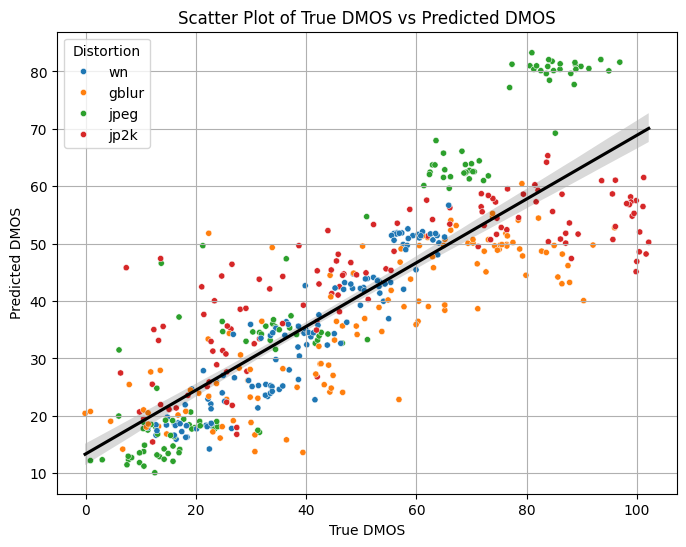

Classification Report:
               precision    recall  f1-score   support

       gblur       0.98      0.95      0.96       125
        jp2k       0.95      0.97      0.96       125
        jpeg       1.00      1.00      1.00       125
          wn       0.99      1.00      1.00       125

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



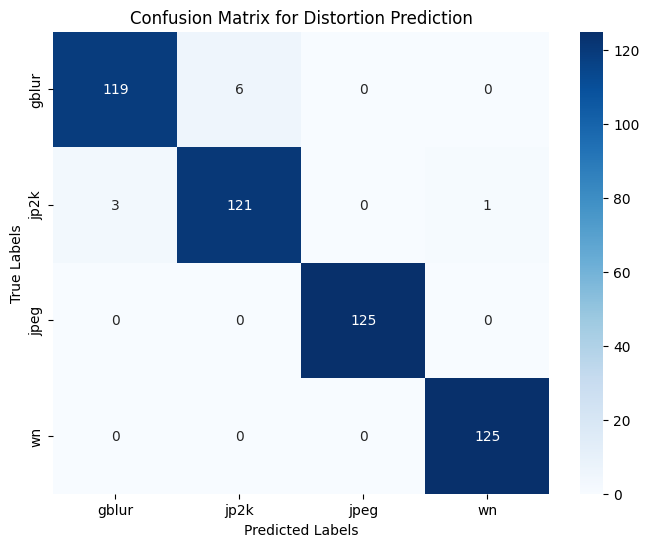

In [13]:
# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=score_measure, y=f'Predicted_{score_measure}', data=merged_df, hue='Distortion', palette='tab10', s=20)
sns.regplot(x=score_measure, y=f'Predicted_{score_measure}', data=merged_df, scatter=False, line_kws={'color': 'black'})
plt.xlabel(f'True {score_measure}')
plt.ylabel(f'Predicted {score_measure}')
plt.title(f'Scatter Plot of True {score_measure} vs Predicted {score_measure}')
plt.grid(True)
plt.show()



from sklearn.metrics import classification_report, confusion_matrix
# Classification report and confusion matrix for distortion predictions
true_distortion = merged_df['Distortion']
predicted_distortion = merged_df['Predicted_Distortion']

# Classification report
class_names = ['gblur', 'jp2k', 'jpeg', 'wn']
report = classification_report(true_distortion, predicted_distortion, target_names=class_names)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(true_distortion, predicted_distortion)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Distortion Prediction')
plt.show()

In [29]:
predicted_distortion.describe()

count      500
unique       4
top       jp2k
freq       130
Name: Predicted_Distortion, dtype: object

In [37]:
for id, row in merged_df.iterrows():
  print(row[4])

wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
wn
wn
blur
blur
blur
blur
blur
jpeg
jpeg
jpeg
jpeg
jpeg
jp2k
jp2k
jp2k
jp2k
jp2k
wn
wn
wn
w